# 3. Anomaly and Event Detection:

ANOMALY DETECTION ANALYSIS

[STEP 1] Loading train_2004.csv data...
Data shape: (6602, 12)
Columns: ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
Target pollutant: CO(GT)
Basic features: ['PT08.S1(CO)', 'T', 'RH', 'AH']

[STEP 2] Residual-based anomaly detection...
Training samples: 5281
Validation samples: 1321
Training Random Forest regressor...
Residual std: 0.5757
Anomaly threshold: ±1.7272
Residual anomalies: 159 (2.41%)

[STEP 3] Unsupervised anomaly detection...
Training Isolation Forest...
Training Local Outlier Factor...
Isolation Forest anomalies: 331 (5.01%)
LOF anomalies: 331 (5.01%)

[STEP 4] Building anomaly table and analysing patterns...

RESIDUAL (SUPERVISED) ANOMALY ANALYSIS
----------------------------------------
Temperature (mean)  Anom: 11.64°C vs Normal: 21.04°C
Weekend ratio  Anom: 0.119 vs Normal: 0.294
Seasonal distribution (proportion):
Winter: Anom 0.560, Normal 0.

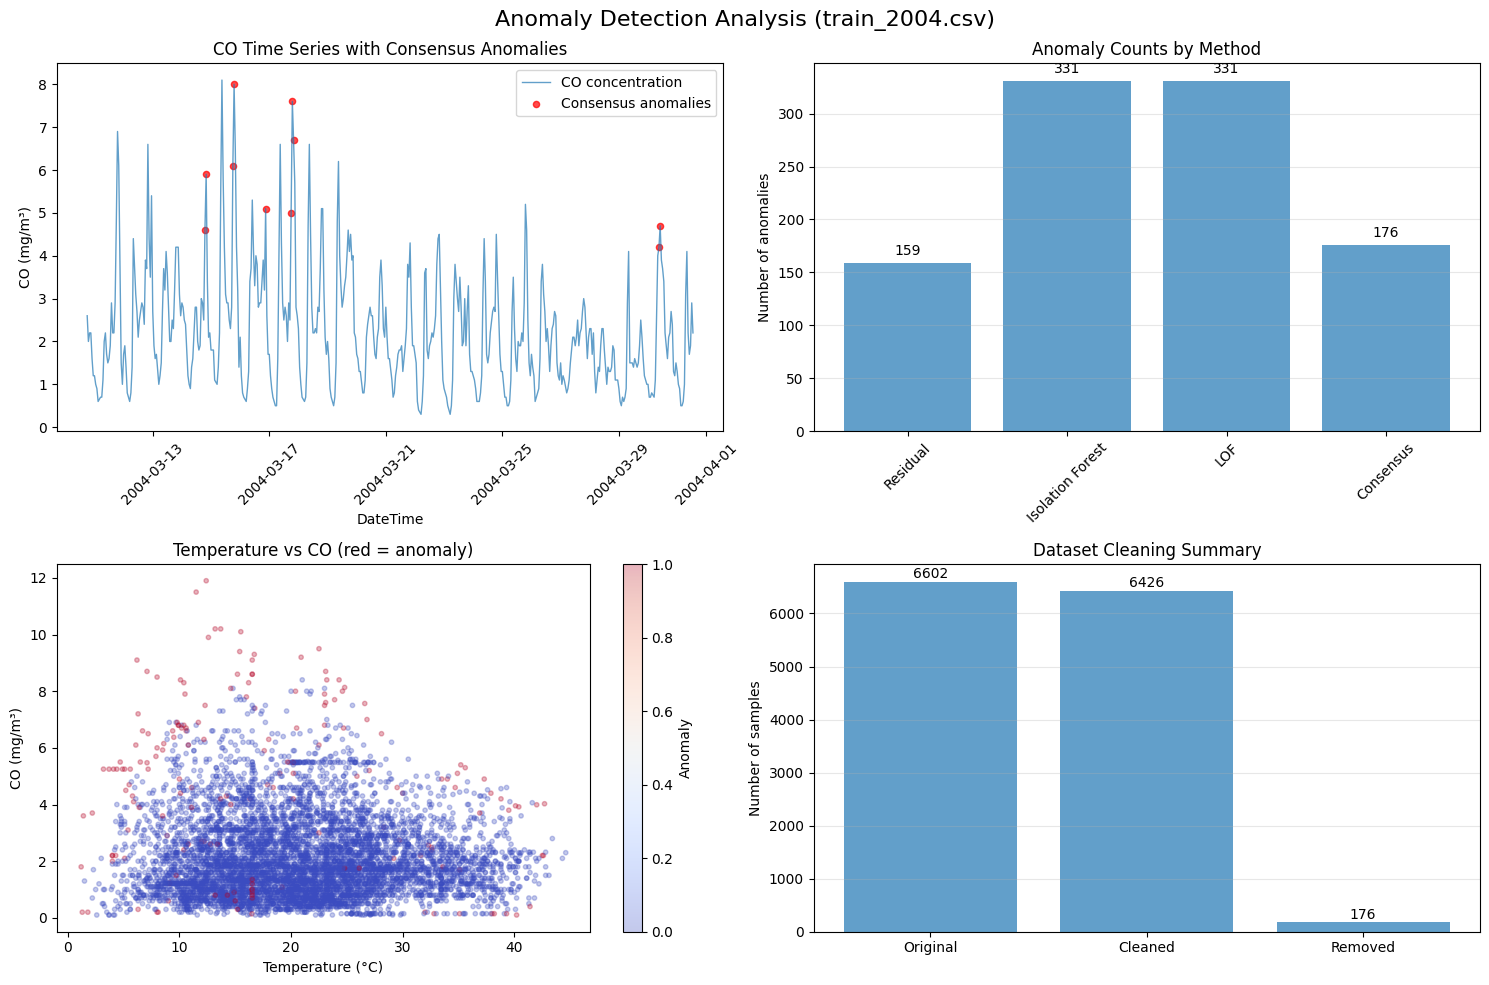

In [1]:
import warnings
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

# ---------------------------------------------------------------------
# Paths and configuration
# ---------------------------------------------------------------------
PROJECT_ROOT = Path("..")  # notebook/ → project root
PREP_DIR = PROJECT_ROOT / "output_Preprocessing_TemporalDataSplitting"
OUTPUT_DIR = PROJECT_ROOT / "output_AnomalyDetection"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("=" * 70)
print("ANOMALY DETECTION ANALYSIS")
print("=" * 70)

# ---------------------------------------------------------------------
# 1. Load 2004 training data from preprocessing step
# ---------------------------------------------------------------------
print("\n[STEP 1] Loading train_2004.csv data...")

df = pd.read_csv(
    PREP_DIR / "train_2004.csv",
    index_col="DateTime",
    parse_dates=True,
)

print(f"Data shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

target_pollutant = "CO(GT)"
basic_features = ["PT08.S1(CO)", "T", "RH", "AH"]

print(f"Target pollutant: {target_pollutant}")
print(f"Basic features: {basic_features}")

# ---------------------------------------------------------------------
# 2. Residual-based anomaly detection (supervised RF regression)
# ---------------------------------------------------------------------
print("\n[STEP 2] Residual-based anomaly detection...")

data_clean = df[basic_features + [target_pollutant]].dropna()
X = data_clean[basic_features]
y = data_clean[target_pollutant]

split_point = int(0.8 * len(X))
X_train = X.iloc[:split_point]
y_train = y.iloc[:split_point]
X_val = X.iloc[split_point:]
y_val = y.iloc[split_point:]

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

print("Training Random Forest regressor...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_full = rf_model.predict(X)
residuals_full = y - y_pred_full

residual_std = residuals_full.std()
threshold = 3 * residual_std
residual_anomalies = np.abs(residuals_full) > threshold

print(f"Residual std: {residual_std:.4f}")
print(f"Anomaly threshold: ±{threshold:.4f}")
print(
    f"Residual anomalies: {residual_anomalies.sum()} "
    f"({residual_anomalies.mean() * 100:.2f}%)"
)

# ---------------------------------------------------------------------
# 3. Unsupervised anomaly detection (Isolation Forest + LOF)
# ---------------------------------------------------------------------
print("\n[STEP 3] Unsupervised anomaly detection...")

unsupervised_features = ["CO(GT)", "PT08.S1(CO)", "T", "RH", "AH"]
X_unsupervised = df[unsupervised_features].dropna()

scaler_unsupervised = StandardScaler()
X_scaled = scaler_unsupervised.fit_transform(X_unsupervised)

print("Training Isolation Forest...")
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_anomalies_raw = iso_forest.fit_predict(X_scaled)
iso_anomalies = iso_anomalies_raw == -1

print("Training Local Outlier Factor...")
lof = LocalOutlierFactor(contamination=0.05, n_neighbors=50)
lof_anomalies_raw = lof.fit_predict(X_scaled)
lof_anomalies = lof_anomalies_raw == -1

print(
    f"Isolation Forest anomalies: {iso_anomalies.sum()} "
    f"({iso_anomalies.mean() * 100:.2f}%)"
)
print(
    f"LOF anomalies: {lof_anomalies.sum()} "
    f"({lof_anomalies.mean() * 100:.2f}%)"
)

# ---------------------------------------------------------------------
# 4. Build unified anomaly DataFrame and inspect temporal patterns
# ---------------------------------------------------------------------
print("\n[STEP 4] Building anomaly table and analysing patterns...")

anomaly_df = X_unsupervised.copy()
anomaly_df["Residual_Anomaly"] = False

residual_anomalies_aligned = pd.Series(residual_anomalies, index=X.index)
common_index = anomaly_df.index.intersection(residual_anomalies_aligned.index)
anomaly_df.loc[common_index, "Residual_Anomaly"] = residual_anomalies_aligned[
    common_index
]

anomaly_df["IsolationForest_Anomaly"] = iso_anomalies
anomaly_df["LOF_Anomaly"] = lof_anomalies

anomaly_df["Hour"] = anomaly_df.index.hour
anomaly_df["DayOfWeek"] = anomaly_df.index.dayofweek
anomaly_df["Month"] = anomaly_df.index.month
anomaly_df["IsWeekend"] = anomaly_df["DayOfWeek"].isin([5, 6])
anomaly_df["Season"] = (anomaly_df["Month"] % 12 + 3) // 3  # 1=W,2=Sp,3=Su,4=Aut


def analyze_anomaly_patterns(anomaly_col: str, name: str) -> None:
    anomalies = anomaly_df[anomaly_col]
    normal = ~anomalies

    print(f"\n{name} ANOMALY ANALYSIS")
    print("-" * 40)

    temp_anom = anomaly_df.loc[anomalies, "T"]
    temp_norm = anomaly_df.loc[normal, "T"]
    print(
        f"Temperature (mean)  Anom: {temp_anom.mean():.2f}°C "
        f"vs Normal: {temp_norm.mean():.2f}°C"
    )

    weekend_anom = anomaly_df.loc[anomalies, "IsWeekend"].mean()
    weekend_norm = anomaly_df.loc[normal, "IsWeekend"].mean()
    print(
        f"Weekend ratio  Anom: {weekend_anom:.3f} "
        f"vs Normal: {weekend_norm:.3f}"
    )

    seasonal_anom = (
        anomaly_df.loc[anomalies, "Season"].value_counts(normalize=True).sort_index()
    )
    seasonal_norm = (
        anomaly_df.loc[normal, "Season"].value_counts(normalize=True).sort_index()
    )
    seasons = ["Winter", "Spring", "Summer", "Fall"]
    print("Seasonal distribution (proportion):")
    for i, season in enumerate(seasons, start=1):
        ar = seasonal_anom.get(i, 0.0)
        nr = seasonal_norm.get(i, 0.0)
        print(f"{season}: Anom {ar:.3f}, Normal {nr:.3f}")

    hourly_anom = (
        anomaly_df.loc[anomalies, "Hour"].value_counts(normalize=True).sort_index()
    )
    print("Top anomaly hours (by frequency):")
    for hour, freq in hourly_anom.head().items():
        print(f"Hour {hour:2d}: {freq:.3f}")


analyze_anomaly_patterns("Residual_Anomaly", "RESIDUAL (SUPERVISED)")
analyze_anomaly_patterns("IsolationForest_Anomaly", "ISOLATION FOREST")
analyze_anomaly_patterns("LOF_Anomaly", "LOCAL OUTLIER FACTOR")

# ---------------------------------------------------------------------
# 5. Enhanced consensus rule (>= 2 methods agree)
# ---------------------------------------------------------------------
print("\n[STEP 5] Enhanced consensus anomaly detection...")

anomaly_df["Enhanced_Consensus_Anomaly"] = (
    anomaly_df["Residual_Anomaly"].astype(int)
    + anomaly_df["IsolationForest_Anomaly"].astype(int)
    + anomaly_df["LOF_Anomaly"].astype(int)
) >= 2

enhanced_consensus_anomalies = anomaly_df["Enhanced_Consensus_Anomaly"]

print("\nENHANCED CONSENSUS (at least 2 of 3 methods):")
print(
    f"Total anomalies: {enhanced_consensus_anomalies.sum()} "
    f"({enhanced_consensus_anomalies.mean() * 100:.2f}%)"
)

analyze_anomaly_patterns("Enhanced_Consensus_Anomaly", "ENHANCED CONSENSUS")

co_threshold_high = anomaly_df["CO(GT)"].quantile(0.95)
pollution_spikes = anomaly_df["CO(GT)"] > co_threshold_high
anomaly_df["Pollution_Spike"] = pollution_spikes

print("\nPOLLUTION SPIKES (top 5% by CO)")
print(f"CO threshold: {co_threshold_high:.3f} mg/m³")
print(
    f"Spikes: {pollution_spikes.sum()} "
    f"({pollution_spikes.mean() * 100:.2f}%)"
)
overlap = (enhanced_consensus_anomalies & pollution_spikes).sum()
print(f"Consensus anomalies that are spikes: {overlap}")

# ---------------------------------------------------------------------
# 6. Generate anomaly flags and cleaned 2004 training set
# ---------------------------------------------------------------------
print("\n[STEP 6] Generating anomaly flags and cleaned dataset...")

anomaly_flags = anomaly_df[["Enhanced_Consensus_Anomaly"]].copy()
anomaly_flags.columns = ["Anomaly_Flag"]
anomaly_flags["Anomaly_Flag"] = anomaly_flags["Anomaly_Flag"].astype(int)

anomaly_flag_path = OUTPUT_DIR / "train_2004_anomaly_flag.csv"
anomaly_flags.to_csv(anomaly_flag_path)
print(f"Saved: {anomaly_flag_path}")


def clean_dataset_with_anomaly_flags(
    original_df: pd.DataFrame, flags: pd.DataFrame
):
    common_idx = original_df.index.intersection(flags.index)
    df_common = original_df.loc[common_idx]
    mask_good = flags.loc[common_idx, "Anomaly_Flag"] == 0

    df_cleaned = df_common[mask_good]
    df_removed = df_common[~mask_good]

    print(f"Original samples:   {len(original_df)}")
    print(f"After cleaning:     {len(df_cleaned)}")
    print(f"Removed anomalies:  {len(df_removed)}")
    print(f"Cleaning rate:      {len(df_removed) / len(original_df) * 100:.2f}%")

    return df_cleaned, df_removed


df_cleaned, df_removed = clean_dataset_with_anomaly_flags(df, anomaly_flags)

cleaned_path = OUTPUT_DIR / "train_2004_cleaned.csv"
removed_path = OUTPUT_DIR / "train_2004_removed.csv"
df_cleaned.to_csv(cleaned_path)
df_removed.to_csv(removed_path)
print(f"Saved: {cleaned_path}")
print(f"Saved: {removed_path}")

# ---------------------------------------------------------------------
# 7. Visualisation (overview figure)
# ---------------------------------------------------------------------
print("\n[STEP 7] Creating visualisations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Anomaly Detection Analysis (train_2004.csv)", fontsize=16, y=0.98)

# (1) CO time series with consensus anomalies
sample_data = anomaly_df.iloc[:500]
axes[0, 0].plot(
    sample_data.index,
    sample_data["CO(GT)"],
    label="CO concentration",
    linewidth=1,
    alpha=0.7,
)
anomaly_points = sample_data[sample_data["Enhanced_Consensus_Anomaly"]]
axes[0, 0].scatter(
    anomaly_points.index,
    anomaly_points["CO(GT)"],
    color="red",
    s=20,
    label="Consensus anomalies",
    alpha=0.7,
)
axes[0, 0].set_xlabel("DateTime")
axes[0, 0].set_ylabel("CO (mg/m³)")
axes[0, 0].set_title("CO Time Series with Consensus Anomalies")
axes[0, 0].legend()
axes[0, 0].tick_params(axis="x", rotation=45)

# (2) Number of anomalies by method
methods = ["Residual", "Isolation Forest", "LOF", "Consensus"]
anomaly_counts = [
    anomaly_df["Residual_Anomaly"].sum(),
    anomaly_df["IsolationForest_Anomaly"].sum(),
    anomaly_df["LOF_Anomaly"].sum(),
    anomaly_df["Enhanced_Consensus_Anomaly"].sum(),
]
axes[0, 1].bar(methods, anomaly_counts, alpha=0.7)
axes[0, 1].set_ylabel("Number of anomalies")
axes[0, 1].set_title("Anomaly Counts by Method")
axes[0, 1].tick_params(axis="x", rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis="y")
for i, count in enumerate(anomaly_counts):
    axes[0, 1].text(i, count + 5, str(count), ha="center", va="bottom")

# (3) Temperature vs CO coloured by consensus anomaly flag
scatter = axes[1, 0].scatter(
    anomaly_df["T"],
    anomaly_df["CO(GT)"],
    c=anomaly_df["Enhanced_Consensus_Anomaly"].astype(int),
    cmap="coolwarm",
    alpha=0.3,
    s=10,
)
axes[1, 0].set_xlabel("Temperature (°C)")
axes[1, 0].set_ylabel("CO (mg/m³)")
axes[1, 0].set_title("Temperature vs CO (red = anomaly)")
plt.colorbar(scatter, ax=axes[1, 0], label="Anomaly")

# (4) Cleaning statistics
cleaning_stats = [len(df), len(df_cleaned), len(df_removed)]
labels = ["Original", "Cleaned", "Removed"]
axes[1, 1].bar(labels, cleaning_stats, alpha=0.7)
axes[1, 1].set_ylabel("Number of samples")
axes[1, 1].set_title("Dataset Cleaning Summary")
axes[1, 1].grid(True, alpha=0.3, axis="y")
for i, count in enumerate(cleaning_stats):
    axes[1, 1].text(i, count + 10, str(count), ha="center", va="bottom")

plt.tight_layout()
fig_path = OUTPUT_DIR / "Anomaly_Analysis.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
print(f"Saved: {fig_path}")

# ---------------------------------------------------------------------
# 8. Precision–recall-style comparison (console only)
# ---------------------------------------------------------------------
print("\n[STEP 8] Precision–recall-style comparison (using spikes as proxy)")

def evaluate_anomaly_method(method_anomalies, true_positives, method_name: str):
    tp = (method_anomalies & true_positives).sum()
    fp = (method_anomalies & ~true_positives).sum()
    fn = (~method_anomalies & true_positives).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

    print(f"\n{method_name}:")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1-score:  {f1:.3f}")


true_positive_proxy = pollution_spikes

print("\nUsing CO spikes (top 5%) as proxy positives:")
evaluate_anomaly_method(anomaly_df["Residual_Anomaly"], true_positive_proxy, "Residual (Supervised)")
evaluate_anomaly_method(anomaly_df["IsolationForest_Anomaly"], true_positive_proxy, "Isolation Forest")
evaluate_anomaly_method(anomaly_df["LOF_Anomaly"], true_positive_proxy, "Local Outlier Factor")
evaluate_anomaly_method(anomaly_df["Enhanced_Consensus_Anomaly"], true_positive_proxy, "Consensus")

# ---------------------------------------------------------------------
# 9. Save summary tables (shorter names)
# ---------------------------------------------------------------------
print("\n[STEP 9] Saving summary tables...")

detailed_path = OUTPUT_DIR / "Anomaly_Detail.csv"
anomaly_df.to_csv(detailed_path)
print(f"Saved: {detailed_path}")

summary_stats = {
    "total_samples": len(anomaly_df),
    "residual_anomalies": anomaly_df["Residual_Anomaly"].sum(),
    "isolation_forest_anomalies": anomaly_df["IsolationForest_Anomaly"].sum(),
    "lof_anomalies": anomaly_df["LOF_Anomaly"].sum(),
    "enhanced_consensus_anomalies": anomaly_df["Enhanced_Consensus_Anomaly"].sum(),
    "pollution_spikes": pollution_spikes.sum(),
    "avg_temperature_anomalies": anomaly_df.loc[anomaly_df["Enhanced_Consensus_Anomaly"], "T"].mean(),
    "avg_temperature_normal": anomaly_df.loc[~anomaly_df["Enhanced_Consensus_Anomaly"], "T"].mean(),
    "weekend_anomaly_rate": anomaly_df.loc[anomaly_df["IsWeekend"], "Enhanced_Consensus_Anomaly"].mean(),
    "weekday_anomaly_rate": anomaly_df.loc[~anomaly_df["IsWeekend"], "Enhanced_Consensus_Anomaly"].mean(),
    "cleaning_rate": len(df_removed) / len(df) * 100,
}

summary_df = pd.DataFrame.from_dict(summary_stats, orient="index", columns=["Value"])
summary_path = OUTPUT_DIR / "Anomaly_Summary.csv"
summary_df.to_csv(summary_path)
print(f"Saved: {summary_path}")

print("\n" + "=" * 70)
print("ANOMALY DETECTION COMPLETE - KEY FINDINGS")
print("=" * 70)

print("\n DETECTION RESULTS:")
print(f" - Residual (Supervised): {summary_stats['residual_anomalies']} anomalies")
print(f" - Isolation Forest: {summary_stats['isolation_forest_anomalies']} anomalies")
print(f" - Local Outlier Factor: {summary_stats['lof_anomalies']} anomalies")
print(f" - Enhanced Consensus (combined): {summary_stats['enhanced_consensus_anomalies']} anomalies")

print("\n METEOROLOGICAL PATTERNS (Consensus anomalies vs normal):")
print(f" - Anomaly avg temperature: {summary_stats['avg_temperature_anomalies']:.2f}°C")
print(f" - Normal avg temperature: {summary_stats['avg_temperature_normal']:.2f}°C")
print(f" - Weekend anomaly rate: {summary_stats['weekend_anomaly_rate']:.3f}")
print(f" - Weekday anomaly rate: {summary_stats['weekday_anomaly_rate']:.3f}")

print("\n DATASETS GENERATED:")
print(f" - train_2004_anomaly_flag.csv: {len(anomaly_flags)} rows")
print(f" - train_2004_cleaned.csv: {len(df_cleaned)} cleaned samples")
print(f" - train_2004_removed.csv: {len(df_removed)} removed anomalies")
print(f" - Cleaning rate: {summary_stats['cleaning_rate']:.2f}%")

print("\nAll results saved to:", OUTPUT_DIR)
print("Main figure: Anomaly_Analysis.png")
print("\nAnomaly detection analysis completed.")